# XGB model hyperparameters tuning

- `xgboost.cv`
- Comparing the optimal candidates by test set, using the g-research weighted correlation metrics.

## 1. cv tuned model folders

- `model_nof_{version number}`

In [1]:
import os
sorted([int(s.split('_')[-1]) for s in os.listdir('./trainedXGB/') if 'model_nof' in s])[-4:]

[24, 25, 26, 27]

## 2. organized data set  

- new_data.ftr

In [2]:
import pandas as pd
import gc
df_train = pd.read_feather('./data'+'/new_data.ftr').drop('index',axis=1)
df_train.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,lr_15,Mkt_lrt_15,Crypto_Index
25721645,1637969940,13,223.0,0.09279,0.09279,0.09233,0.09244,1.521243e+06,0.092560,-0.000391,1.791759,-0.001621,-0.000248,9722.884203
25721646,1637970000,13,83.0,0.09243,0.09259,0.09243,0.09248,5.092429e+05,0.092510,0.001020,1.791759,-0.001405,-0.000394,9717.191057
25721647,1637970060,13,106.0,0.09248,0.09248,0.09222,0.09222,7.567872e+05,0.092350,0.000418,1.791759,-0.003032,-0.001616,9703.766097
25721648,1637970120,13,144.0,0.09223,0.09233,0.09204,0.09204,8.175301e+05,0.092185,0.000359,1.791759,-0.004120,-0.003710,9689.570606
25721649,1637970180,13,105.0,0.09203,0.09218,0.09201,0.09204,6.645793e+05,0.092095,0.000705,1.791759,-0.003579,-0.003412,9679.574846


Weighted info `lr_mkt_resid` similar to `Target` which can remove the market signal from individual asset returns. 

$$R^{a}(t)=\log P^{a}_t - \log P^{a}_{t-15}$$

$$M(t)=\frac{\sum_{a} w^{a} R^{a}(t)}{\sum_{a} w^{a}}$$

$$\beta^{a}=\frac{\left\langle M \cdot R^{a}\right\rangle_{60}}{\left\langle M^{2}\right\rangle_{60}}$$

$$lrmktresid^{a}(t)=R^{a}(t)-\beta^{a} M(t)$$

where the bracket  $⟨.⟩_{60}$ represent the rolling average over time (60 minute windows).

In [3]:
import talib as ta
import numpy as np

df_train.set_index(['timestamp','Asset_ID'],inplace=True)
def beta(df, window=60): 
    b = (ta.MULT(df.Mkt_lrt_15,df.lr_15).rolling(window).mean())/(ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).rolling(window).mean())
    return b

def lr_mkt_resid(df):
    return ta.SUB(df.lr_15, ta.MULT(df.beta, df.Mkt_lrt_15))

##make beta
ddd = df_train.groupby("Asset_ID").apply(lambda x: beta(x)).rename("beta").to_frame().reset_index(0,drop=True)
ddd=ddd.replace([np.nan,np.inf,-np.inf], 0)
df_train= df_train.merge(ddd, on =['Asset_ID','timestamp'],how='left')

##make lr_mkt_resid
df_train['lr_mkt_resid'] = lr_mkt_resid(df_train) 

del ddd
gc.collect()

df_train.reset_index(inplace=True)
df_train.tail()

,Asset_ID,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,lr_15,Mkt_lrt_15,Crypto_Index,beta,lr_mkt_resid
25721645,13,1637969940,223.0,0.09279,0.09279,0.09233,0.09244,1.521243e+06,0.092560,-0.000391,1.791759,-0.001621,-0.000248,9722.884203,0.854247,-0.001410
25721646,13,1637970000,83.0,0.09243,0.09259,0.09243,0.09248,5.092429e+05,0.092510,0.001020,1.791759,-0.001405,-0.000394,9717.191057,0.854387,-0.001068
25721647,13,1637970060,106.0,0.09248,0.09248,0.09222,0.09222,7.567872e+05,0.092350,0.000418,1.791759,-0.003032,-0.001616,9703.766097,0.855892,-0.001649
25721648,13,1637970120,144.0,0.09223,0.09233,0.09204,0.09204,8.175301e+05,0.092185,0.000359,1.791759,-0.004120,-0.003710,9689.570606,0.858245,-0.000936
25721649,13,1637970180,105.0,0.09203,0.09218,0.09201,0.09204,6.645793e+05,0.092095,0.000705,1.791759,-0.003579,-0.003412,9679.574846,0.859509,-0.000646


## 3. Features

In [4]:
from script.XGB.xgbmodel import get_features
pd.options.mode.chained_assignment = None  # default='warn'
#df_train.groupby('Asset_ID').apply(lambda x: get_features(x, lagfeatures=True))
def log_return(series, periods=5):
    return np.log(series).diff(periods)

def upper_shadow(df):
    return ta.SUB(df['High'], np.maximum(df['Close'], df['Open']))

def lower_shadow(df):
    return ta.SUB(np.minimum(df['Close'], df['Open']), df['Low'] )

def lag_features(df):
    #Close-log-return
    df['lrtn_close_5'] = log_return(df['Close'],periods=5)
    df['lrtn_close_15'] = log_return(df['Close'],periods=15)
    df['lrtn_index_5'] = log_return(df['Crypto_Index'],periods=5)
    df['lrtn_index_15'] = log_return(df['Crypto_Index'],periods=15)
    
    #lr_mkt_resid sma
    df['lr_mkt_resid_sma'] = ta.SMA(df['lr_mkt_resid'],5)
    
    #15minutes-volume-sum/delta, on-balance-volume
    df['vol_sum_15'] = ta.SMA(df['Volume'],15)*15
    df['vol_delta_15'] = df['vol_sum_15'].diff()
    df['vol_pressure_1']=np.sign(df['Close'].diff(1)) * df['Volume']
    df['vol_pressure_15']=ta.MULT(np.sign(df['Close'].diff(15)), df['vol_sum_15'])
    
    #tech analysis indicators
    df['willr'] = ta.WILLR(df['High'], df['Low'],df['Close'], timeperiod=15)
    df['adx'] = ta.ADX(df['High'], df['Low'],df['Close'],timeperiod=15)
    df['DI_plus'] = ta.PLUS_DI(df['High'], df['Low'],df['Close'], timeperiod=14)
    df['DI_minus'] = ta.MINUS_DI(df['High'], df['Low'],df['Close'], timeperiod=14)
    df['ROCP'] =ta.ROCP(df['Open'])
    df['momentam'] =ta.MOM(df['Open'])
    df['APO'] =ta.APO(df['Open'])
    df['PPO'] =ta.PPO(df['Open'])
    df['CMO'] =ta.CMO(df['Open'])
    df['MIDPOINT'] =ta.MIDPOINT(df['Open'])
    df['TRENDLINE'] =ta.HT_TRENDLINE(df['Open'])
    
    df['rsi_15'] = ta.RSI(df['Close'], timeperiod=15)
    df['macd_15_30'],df['macd_signal'], df['macd_hist'] = ta.MACD(df['Close'], fastperiod=15, slowperiod=30, signalperiod=5)
    band_up, mid_band, band_down = ta.BBANDS(df['Close'], timeperiod=15, nbdevup=2, nbdevdn=2, matype=0)
    df['close_bollinger_up_15'] = ta.SUB(band_up, df['Close'])
    df['close_bollinger_down_15'] = ta.SUB(df['Close'], band_down)

def get_features(df_feat):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    lag_features(df_feat)
    return df_feat

## 4. Test set range

- train set range is after `df_train['timestamp'].quantile(0.5)`
- test set

In [5]:
df_train['timestamp'].quantile(0.5)

1581021420.0

In [6]:
pd.to_datetime(df_train['timestamp'].quantile(0.5),unit="s",
               infer_datetime_format=True)

Timestamp('2020-02-06 20:37:00')

In [7]:
int(pd.Timestamp('2021-09-21T00:00:00').timestamp())

1632182400

In [8]:
import datetime
import time

#test_days= 30*3
def make_testset(df_train, start,end):
    dd = df_train[(start<=df_train['timestamp']) & (df_train['timestamp']<=end)].copy()
    ###consistent timestamp for all 14 assets
    dd = dd.sort_values('timestamp').set_index("timestamp").sort_index()
    ind = dd.index.unique()
    def reindex(df):
        df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df
    dd = dd.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
    ###add features
    dd = dd.groupby('Asset_ID').apply(lambda x: get_features(x))
    dd.dropna(axis = 0, inplace= True)
    return dd.reset_index()
    
################################################out-train test
test_end= df_train['timestamp'].max()
test_start= df_train['timestamp'].quantile(0.95)
df_test = make_testset(df_train, test_start,test_end)

#############################################in-train test same as API
test_end2= 1632182400
test_start2= 1623542400 - 60*64
df_test2 = make_testset(df_train, test_start2,test_end2)


In [9]:
del df_train
gc.collect()
df_test.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,PPO,CMO,MIDPOINT,TRENDLINE,rsi_15,macd_15_30,macd_signal,macd_hist,close_bollinger_up_15,close_bollinger_down_15
1285237,1637970180,9,155.0,194.899994,195.500000,194.899994,195.199997,755.846008,195.199997,0.000064,...,-0.180967,-32.381156,196.000000,196.821859,38.268429,-0.369550,-0.342710,-0.026840,1.877502,0.677494
1285238,1637970180,10,20.0,3105.000000,3107.000000,3104.000000,3105.000000,0.603900,3105.500000,-0.004860,...,-0.199612,-32.950710,3120.500000,3134.684291,34.692924,-6.038245,-5.349773,-0.688472,31.190608,6.657275
1285239,1637970180,11,12.0,223.899994,224.100006,223.899994,223.899994,12.926000,224.000000,0.012574,...,-0.078031,-24.677380,225.150002,225.530036,38.935561,-0.187040,-0.124157,-0.062883,2.827590,1.067583
1285240,1637970180,12,105.0,0.327600,0.328500,0.327400,0.327500,102431.000000,0.327950,0.002122,...,-0.115673,-25.639094,0.328850,0.330000,37.681768,-0.000622,-0.000602,-0.000020,0.003169,0.001196
1285241,1637970180,13,105.0,0.092030,0.092180,0.092010,0.092040,664579.312500,0.092095,0.000705,...,-0.176501,-31.636466,0.092410,0.092731,35.011971,-0.000133,-0.000114,-0.000019,0.000789,0.000185


## Performance on test set

In [10]:
import xgboost as xgb
from os.path import exists

ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

def model_reload_train(param_version):
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        model_file = f"./trainedXGB/model_nof_{param_version}/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

In [11]:
from script.weighted_corr_metrics import weighted_correlation

result = []
result2 = []
models = {}
for version_num in sorted([int(s.split('_')[-1]) for s in os.listdir('./trainedXGB/') if 'model_nof' in s])[-2:]:
    models[version_num] =model_reload_train(param_version= version_num)
    result_id=[]
    result_id2=[]
    for id in range(0,14):
        model = models[version_num][id]
        x = df_test[df_test['Asset_ID']==id]
        x['Pred'] = model.predict(xgb.DMatrix(x[model.feature_names]))
        result_id.append(x[['timestamp','Asset_ID','Weight','Target','Pred']])
        x2 = df_test2[df_test2['Asset_ID']==id]
        x2['Pred2'] = model.predict(xgb.DMatrix(x2[model.feature_names]))
        result_id2.append(x2[['timestamp','Asset_ID','Weight','Target','Pred2']])
        
    result.append(pd.concat(result_id, axis=0))
    result2.append(pd.concat(result_id2, axis=0))
    score=weighted_correlation(a=result[-1]['Target'], 
                     b=result[-1]['Pred'], 
                     weights=result[-1]['Weight'])
    score2=weighted_correlation(a=result2[-1]['Target'], 
                     b=result2[-1]['Pred2'], 
                     weights=result2[-1]['Weight'])
    #print(f"features: {models[0].feature_names}")
    print(f'model_nof_{version_num} finished. Out-train-score:{score}, In-train-score:{score2}')

model_nof_26 finished. Out-train-score:0.010519249799822184, In-train-score:0.3356269741876345
model_nof_27 finished. Out-train-score:0.0014459903178563947, In-train-score:0.5145631135804853


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

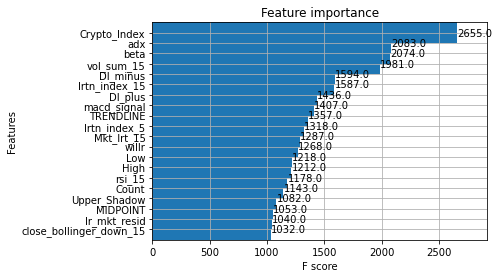

In [12]:
xgb.plot_importance(models[26][13], max_num_features=20, height=2)

In [13]:
models[26][5].feature_names

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'VWAP',
 'Weight',
 'lr_15',
 'Mkt_lrt_15',
 'Crypto_Index',
 'beta',
 'lr_mkt_resid',
 'Upper_Shadow',
 'Lower_Shadow',
 'lrtn_index_5',
 'lrtn_index_15',
 'lr_mkt_resid_sma',
 'vol_sum_15',
 'vol_delta_15',
 'vol_pressure_1',
 'vol_pressure_15',
 'willr',
 'adx',
 'DI_plus',
 'DI_minus',
 'ROCP',
 'momentam',
 'APO',
 'PPO',
 'CMO',
 'MIDPOINT',
 'TRENDLINE',
 'rsi_15',
 'macd_15_30',
 'macd_signal',
 'macd_hist',
 'close_bollinger_up_15',
 'close_bollinger_down_15']

In [14]:
!cat trainedXGB/model_nof_25/params_xgb25.txt

{"booster": "gbtree", "verbosity": 0, "validate_parameters": 1, "learning_rate": 0.1, "min_split_loss": 0, "max_depth": 10, "min_child_weight": 0.6, "subsample": 0.7, "colsample_bytree": 0.3, "reg_lambda": 0.4, "reg_alpha": 1.2, "max_delta_step": 0, "scale_pos_weight": 1, "tree_method": "gpu_hist", "predictor": "gpu_predictor", "num_parallel_tree": 1, "objective": "reg:squarederror", "eval_metric": "rmse", "base_score": 0.5, "seed": 2021}